## 3. Autoencoders (AEs) en MNIST
Como se ha discutido en clases, las RBM’s y posteriormente los AE’s (redes no supervisadas) fueron un componente crucial en el desarrollo de los modelos que entre 2006 y 2010 vigorizaron el área de las redes neuronales artificiales con logros notables de desempeño en diferentes tareas de aprendizaje automático. En esta sección aprenderemos a utilizar el más sencillo de estos modelos: un autoencoder o AE. Consideraremos tres aplicaciones clásicas: reducción de dimensionalidad, denoising y pre-entrenamiento. Con este objetivo en mente, utilizaremos un dataset denominado MNIST. Se trata de una colección de 70000 imágenes de 28 $\times$ 28 pixeles correspondientes a dígitos manuscritos (números entre 0 y 9). En su versión tradicional, la colección se encuentra separada en dos subconjuntos: uno de entrenamiento de 60000 imágenes y otro de test de 10000 imágenes. La tarea consiste en construir un programa para que aprenda a identificar correctamente el dı́gito representado en la imagen

> a) Escriba una función que cargue los datos desde el repositorio de keras, normalice las imágenes de modo que los pixeles queden en [0, 1], transforme las imágenes en vectores ($\in {\rm I\!R}^{784}$) y devuelva tres subconjuntos disjuntos: uno de entrenamiento, uno de validación y uno de pruebas. Construya el conjunto de validación utilizando los últimos $nval = 5000$ casos del conjunto del entrenamiento. El conjunto de entrenamiento consistirá en las primeras $60000 - nval$ imágenes.

Primero importamos las librerías necesarias para la experimentación.

In [1]:
%matplotlib inline
import time
import numpy as np
import matplotlib.pyplot as plt

from keras import backend
from keras.datasets import mnist
from keras.utils import np_utils
from keras.layers import Input, Dense
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model
from keras.optimizers import SGD
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from numpy.random import binomial
from numpy.random import gamma

Using TensorFlow backend.


Cargamos los datos del MNIST handwritten digit database.

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255. #and x_test
x_test = x_test.astype('float32') / 255.

Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [0]:
print("x_train size: {}".format(x_train.shape))
print("x_test size: {}".format(x_test.shape))
print("Y_train size: {}".format(Y_train.shape))
print("Y_test size: {}".format(Y_test.shape))

x_train size: (60000, 28, 28)
x_test size: (10000, 28, 28)
Y_train size: (60000, 10)
Y_test size: (10000, 10)


De los 70.000 datos 60.000 serán utilizados para el entrenamiento (considerando los datos de evaluación) y 10.000 se ocuparán para el testing.

El conjunto de validación no se extraerá directamente de los datos, sino que mediante el parámetro *validation_split* que toma un valor en [0,1]. Este es el porcentaje de datos de entrenamiento que toma para realizar la validación. Como se utilizarán 5000 datos de validación el parametro a entregar será $val\_ratio= 5000/60000$.

In [2]:
val_ratio = 5000/60000
print("Porcertanje de datos para validación: %.4f" % val_ratio)

Porcertanje de datos para validación: 0.0833


Un ejemplo del dataset se visualiza a continuación. Los datos vienen en forma de matriz con dimensiones $28\times28$.

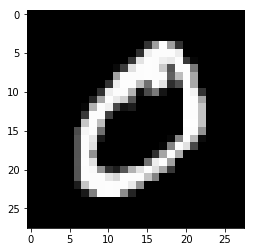

In [0]:
plt.imshow(x_train[1], cmap='gray')
plt.show()


### 3.1 Reducción de dimensionalidad
Para esta primera sección se trabajará con un autoencoder tradicional (*feed forward*) en donde las capas de este son densas. Para esto se re estructuraran los datos de entradas en forma de vector, es decir la matriz de 28 $\times$ 28 pasa a ser un vector de 784 componentes.

In [0]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print("x_train size: {}".format(x_train.shape))
print("x_test size: {}".format(x_test.shape))

x_train size: (60000, 784)
x_test size: (10000, 784)


En vez de trabajar con matrices se trabajará con vectores.

Una de las aplicaciones tı́picas de un AE es reducción de dimensionalidad, es decir, implementar una transformación $\phi:{\rm I\!R}^d \leftarrow {\rm I\!R}^{d'}$ de objetos representados originalmente por $d$ atributos en una nueva representación de $d'$ atributos, de modo tal que se preserve lo mejor posible la “información” original. Obtener tal representación es útil desde un punto de vista computacional (compresión) y estadı́stico (permite construir modelos con un menor número de parámetros libres). Un AE es una técnica de reducción de dimensionalidad no supervisada porque no hace uso de información acerca de las clases a las que pertenecen los datos de entrenamiento

> a) Entrene un AE básico (1 capa escondida) para generar una representación de MNIST en $d'$= 2, 8, 32, 64 dimensiones. Justifique la elección de la función de pérdida a utilizar y del criterio de entrenamiento en general. Determine el porcentaje de compresión obtenido y el error de reconstrucción en cada caso. ¿Mejora el resultado si elegimos una función de activación **ReLU** para el Encoder? ¿Podrı́a utilizarse esta activación en el Decoder?

# explicar autoencoder
# explicar eleccion de mse

In [0]:
sigmoid_results = []
dims = [2, 8, 32, 64]
for dim in dims:
    start_time = time.time()
    input_img = Input(shape=(784,))
    encoded = Dense(dim, activation='sigmoid')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(input=input_img, output=decoded)
    encoder = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

    autoencoder.compile(optimizer=SGD(lr=1.0), loss='mean_squared_error', metrics=['accuracy'])
    hist = autoencoder.fit(x_train,x_train,epochs=50,batch_size=32,validation_split=val_ratio,verbose=0)
    duration = time.time() - start_time
    sigmoid_results.append(hist.history)
    autoencoder.save('ae_p2/basic_ae_sigmoid_768x'+str(dim)+'.h5')
    print("Tiempo total AE sigmoid dim={} t={}s".format(dim, duration))

/home/nacho/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  
/home/nacho/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':
/home/nacho/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if sys.path[0] == '':


Tiempo total AE sigmoid dim=2 t=146.08135771751404s
Tiempo total AE sigmoid dim=8 t=154.39099717140198s
Tiempo total AE sigmoid dim=32 t=161.80759501457214s
Tiempo total AE sigmoid dim=64 t=168.56948137283325s


En término de tiempo de ejecución, a mayor dimensionalidad mayor fue el tiempo de ejecución. No obtante anteriormente se ejecutó el mismo bloque de código y los tiempo no fueron crecientes.

Se grafican los resultados de accuracy y loss para entrenamiento y testing.

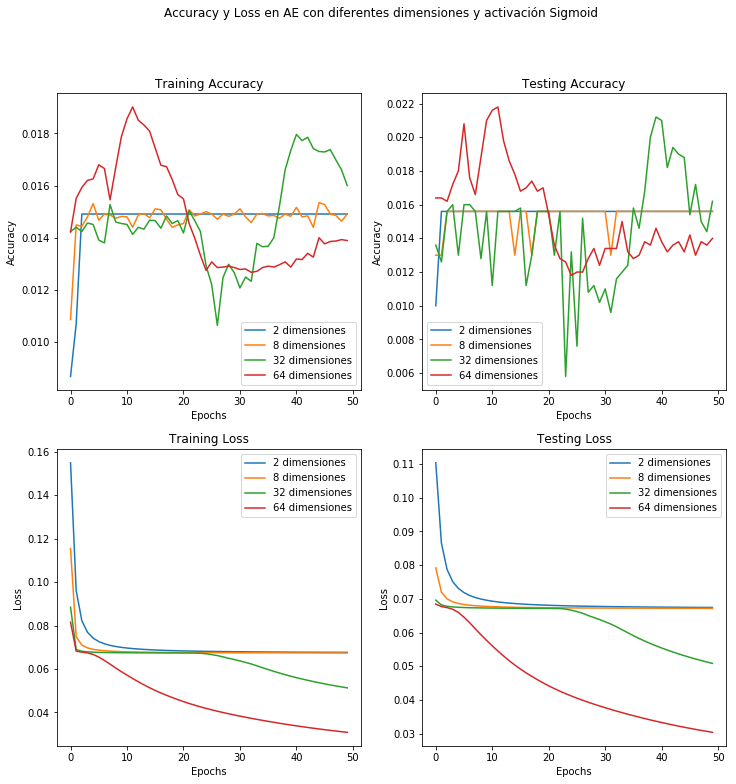

In [0]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,12))
ax = axes.flatten()
for i,dim in enumerate(dims):
    ax[0].plot(sigmoid_results[i]["acc"], label=str(dim)+" dimensiones")
    ax[1].plot(sigmoid_results[i]["val_acc"], label=str(dim)+" dimensiones")
    ax[2].plot(sigmoid_results[i]["loss"], label=str(dim)+" dimensiones")
    ax[3].plot(sigmoid_results[i]["val_loss"], label=str(dim)+" dimensiones")
    
ax[0].set_title('Training Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend()
ax[1].set_title('Testing Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()
ax[2].set_title('Training Loss')
ax[2].set_ylabel('Loss')
ax[2].set_xlabel('Epochs')
ax[2].legend()
ax[3].set_title('Testing Loss')
ax[3].set_ylabel('Loss')
ax[3].set_xlabel('Epochs')
ax[3].legend()
plt.suptitle("Accuracy y Loss en AE con diferentes dimensiones y activación Sigmoid")
plt.show()

Los gráficos de accuracy tienen una fluctuación en los valores a medida que aumentan los epochs. Para las dos primeras dimensiones se llega a un estado constante a los pocos epochs. Para las dos siguiente funciones dim=64 parte siendo muy buena pero a los 20 epochs baja la accuracy siendo la peor de las 4. Para dim=32 sucede lo contrario.

En el caso de la función de pérdida se tiene un mejor resultado de reconstrucción con dimensión=64 estando muy por debajo del resto. Para dim=2 y dim=8 se repite el comportamiento de quedar constante a las pocas iteraciones sobre los datos de entrenamiento.

Ahora probaremos con el mismo AR pero con función relu, esperando tener resultados diferentes.

In [0]:
relu_results = []

for dim in dims:
    start_time = time.time()
    input_img = Input(shape=(784,))
    encoded = Dense(dim, activation='relu')(input_img)
    decoded = Dense(784, activation='relu')(encoded)
    autoencoder = Model(input=input_img, output=decoded)
    encoder = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

    autoencoder.compile(optimizer=SGD(lr=1.0), loss='mean_squared_error', metrics=['accuracy'])
    hist = autoencoder.fit(x_train,x_train,epochs=50,batch_size=32,validation_split=val_ratio,verbose=0)
    duration = time.time() - start_time
    relu_results.append(hist.history)
    autoencoder.save('ae_p2/basic_ae_relu_768x'+str(dim)+'.h5')
    print("Tiempo total AE relu dim={} t={}s".format(dim, duration))

/home/nacho/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  
/home/nacho/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':
/home/nacho/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if sys.path[0] == '':


Tiempo total AE relu dim=2 t=147.75272822380066s
Tiempo total AE relu dim=8 t=150.7963261604309s
Tiempo total AE relu dim=32 t=167.0249800682068s
Tiempo total AE relu dim=64 t=192.97245073318481s


El uso de Relu hizo que aumentarán los tiempos de entrenamiento. En este caso se dio que al aumentar la dimensión aumentó el tiempo.

Graficamos los resultados de los AE.

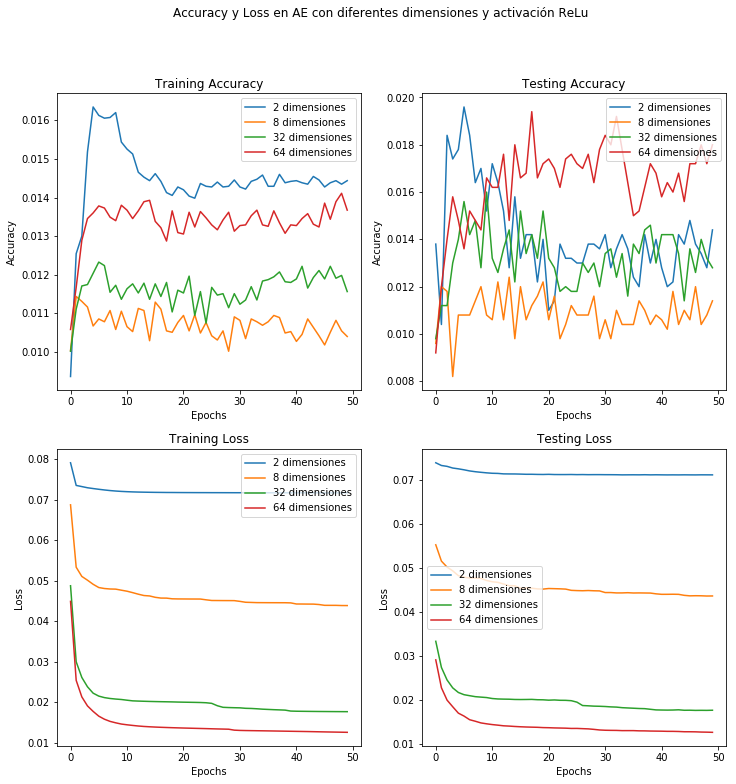

In [0]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,12))
ax = axes.flatten()
for i,dim in enumerate(dims):
    ax[0].plot(relu_results[i]["acc"], label=str(dim)+" dimensiones")
    ax[1].plot(relu_results[i]["val_acc"], label=str(dim)+" dimensiones")
    ax[2].plot(relu_results[i]["loss"], label=str(dim)+" dimensiones")
    ax[3].plot(relu_results[i]["val_loss"], label=str(dim)+" dimensiones")
    
ax[0].set_title('Training Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend()
ax[1].set_title('Testing Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()
ax[2].set_title('Training Loss')
ax[2].set_ylabel('Loss')
ax[2].set_xlabel('Epochs')
ax[2].legend()
ax[3].set_title('Testing Loss')
ax[3].set_ylabel('Loss')
ax[3].set_xlabel('Epochs')
ax[3].legend()
plt.suptitle("Accuracy y Loss en AE con diferentes dimensiones y activación ReLu")
plt.show()

Utilizando ReLu en el entrenamiento se reduce la pérdida a medida que aumenta la dimensionalidad. Esto significa que las reconstrucciones serán mejores. No obstante la cercanía de los resultados para dim=32 y dim=64 darían a entender que para cierta dimensionalidad ya no comienza a mejorar con tal diferencia como pasa con dim=2 y dim=8.

Los gráficos de acurracy tienen una mayor fluctuación y no hay clara tendencia de los resultados.

Finalmente, Relu si sería una opción viable para el entrenamiento.

> b) Compare visualmente la reconstrucción que logra hacer el autoencoder desde la representación en ${\rm I\!R}^{d'}$ para algunas imágenes del conjunto de pruebas. Determine si la percepción visual se corresponde con el error de reconstrucción observada. Comente.

In [0]:
dims = [2, 8, 32, 64]
def show_results(dims, activation):
    for dim in dims:
        print("AE activación:{}\tdim:{}".format(activation,dim))
        autoencoder = load_model("./ae_p2/basic_ae_"+activation+"_768x"+str(dim)+".h5")
        inputs = autoencoder.input
        encoder_layer = autoencoder.layers[-2]
        encoder = Model(inputs=inputs, outputs=encoder_layer(inputs))
        decoded_shape = Input(shape=(dim,))
        decoder_layer = autoencoder.layers[-1] 
        decoder = Model(inputs=decoded_shape, outputs=decoder_layer(decoded_shape))
        
        encoded_test = encoder.predict(x_test)
        decoded_test = decoder.predict(encoded_test)
        print("error[Loss, Acc]:{}".format(autoencoder.evaluate(x_test,x_test)))

        n = 10
        plt.figure(figsize=(20, 4))
        for i in range(n):
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(decoded_test[i].reshape(28, 28),cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

AE activación:sigmoid	dim:2
10000/10000 [==============================] - 0s 50us/step
error[Loss, Acc]:[0.06784658191204071, 0.0161]


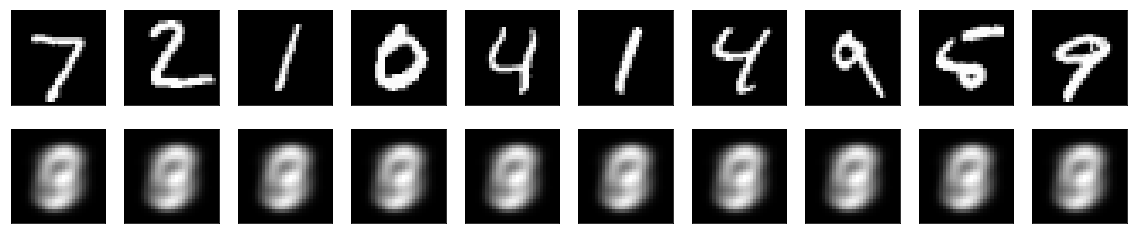

AE activación:sigmoid	dim:8
10000/10000 [==============================] - 0s 50us/step
error[Loss, Acc]:[0.06758099347352982, 0.0161]


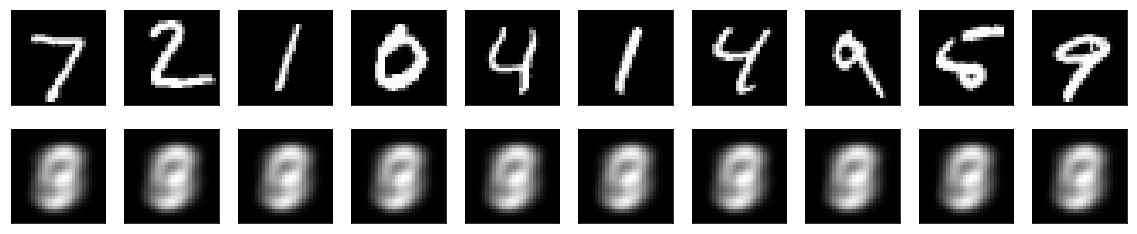

AE activación:sigmoid	dim:32
10000/10000 [==============================] - 1s 66us/step
error[Loss, Acc]:[0.05094187282323837, 0.0168]


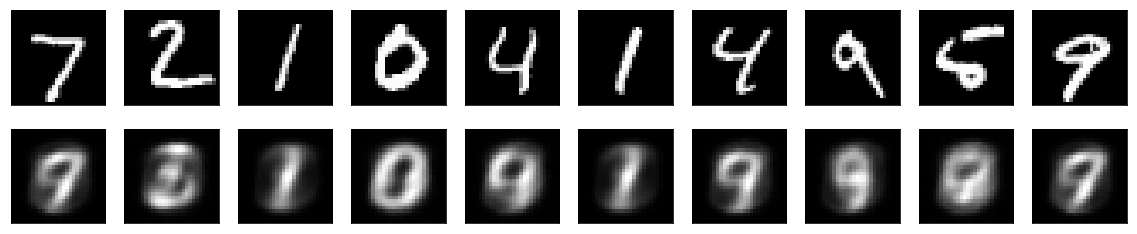

AE activación:sigmoid	dim:64
10000/10000 [==============================] - 0s 47us/step
error[Loss, Acc]:[0.030322149845957755, 0.0118]


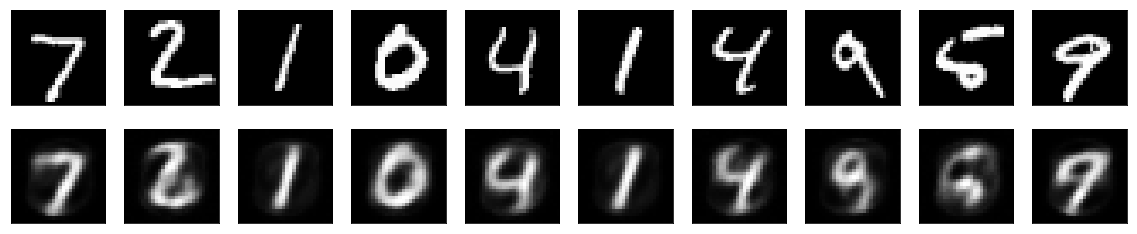

In [0]:
show_results(dims, 'sigmoid')

AE activación:relu	dim:2
10000/10000 [==============================] - 0s 46us/step
error[Loss, Acc]:[0.07193156352043152, 0.0146]


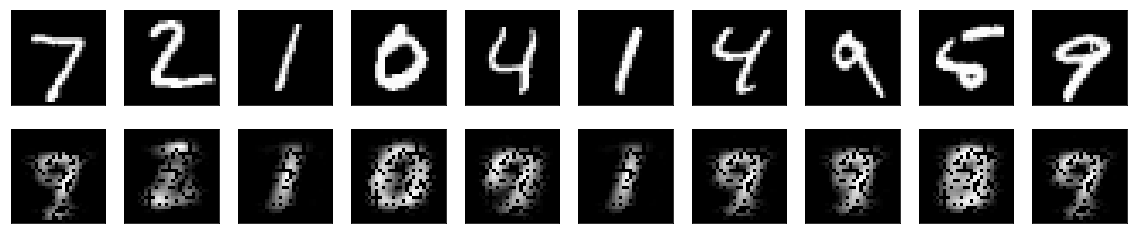

AE activación:relu	dim:8
10000/10000 [==============================] - 0s 45us/step
error[Loss, Acc]:[0.04371277124881744, 0.0125]


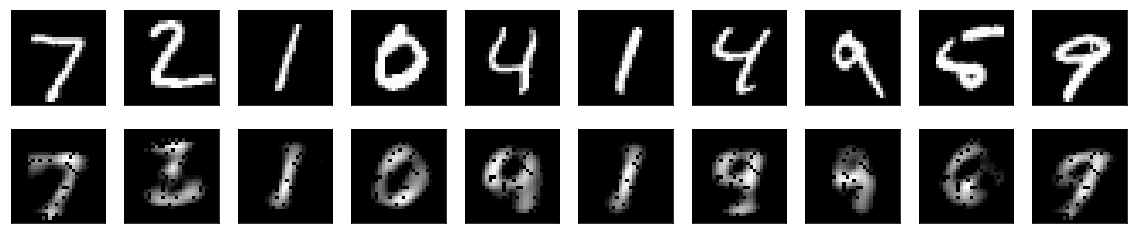

AE activación:relu	dim:32
10000/10000 [==============================] - 0s 46us/step
error[Loss, Acc]:[0.017569315341115, 0.0128]


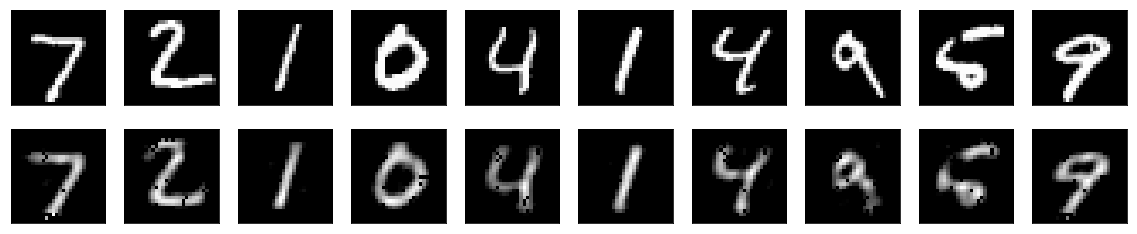

AE activación:relu	dim:64
10000/10000 [==============================] - 1s 60us/step
error[Loss, Acc]:[0.012379439428448677, 0.0119]


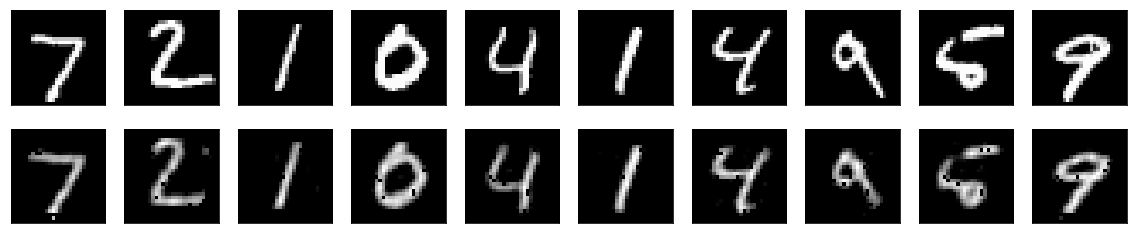

In [0]:
show_results(dims, 'relu')


> c) Para verificar la calidad de la representación obtenida, implemente el clasificador denominado $kNN$ (k-nearest neighbor): dada una imagen $x$, el clasificador busca las k = 10 imágenes de entrenamiento más similares (de acuerdo a una distancia, e.g. euclidiana) y predice como clase, la etiqueta más popular entre las imágenes cercanas. Mida el error de pruebas obtenido construyendo este clasificador sobre la data reducida a través del autocnder comparando con la representación reducida obtenida vía PCA (una técnica clásica de reducción de dimensionalidad) utilizando el mismo número de dimensiones $d'$= 2, 4, 8, 16, 32. Considere tanto el error de reconstrucción como el desempeño en clasificación , además de comparar los tiempos medios de predicción en ambos escenarios.

Primero se generarán los modelos para d = 4 y d = 16.

In [0]:
dims = [4, 16]
for dim in dims:
    start_time = time.time()
    input_img = Input(shape=(784,))
    encoded = Dense(dim, activation='relu')(input_img)
    decoded = Dense(784, activation='relu')(encoded)
    autoencoder = Model(input=input_img, output=decoded)
    encoder = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

    autoencoder.compile(optimizer=SGD(lr=1.0), loss='mean_squared_error', metrics=['accuracy'])
    autoencoder.fit(x_train,x_train,epochs=50,batch_size=32,validation_split=val_ratio,verbose=0)
    duration = time.time() - start_time
    autoencoder.save('ae_p2/basic_ae_relu_768x'+str(dim)+'.h5')
    print("Tiempo total AE relu dim={} t={}s".format(dim, duration))

/home/nacho/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys
/home/nacho/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  
/home/nacho/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


Tiempo total AE relu dim=4 t=177.13644981384277s
Tiempo total AE relu dim=16 t=167.42113280296326s


PCA (*Principal Component Analysis*) es una técnica de reducción de dimensionalidad que busca llevar elementos de dimensiones superiores a reducciones que contengan una mayor cantidad de información. Esta técnica es muy usada para el estudio y visualización de problemas en alta dimensionalidad, donde no es posible hacer gráficos de más de tres dimensiones.

Se buscará comparar el error de prueba de la reducción del AE comparándolo con la representación de PCA.

In [0]:
dims = [2,4,8,16,32,64]

for d in dims:
    print("Dimensión utilizada: %d" % d)
    #PCA
    pca = PCA(n_components=d)
    pca.fit(x_train)
    pca_train = pca.transform(x_train)
    pca_test = pca.transform(x_test)
    #AUTOENCODER
    encoder = load_model("./ae_p2/basic_ae_relu_768x"+str(d)+".h5")
    encoded_train = encoder.predict(x_train)
    encoded_test = encoder.predict(x_test)
    #CLASIFICATION
    start_time = time.time()
    clf = KNeighborsClassifier(10)
    clf.fit(pca_train, y_train)
    print("-Classification Accuracy PCA %.2f" % clf.score(pca_test,y_test))
    print("--Tiempo:{:.4f}".format(time.time()-start_time))
    start_time = time.time()
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, y_train)
    print("-Classification Accuracy %.2f" % clf.score(encoded_test,y_test))
    print("--Tiempo:{:.4f}\n".format(time.time()-start_time))


Dimensión utilizada: 2
-Classification Accuracy PCA 0.44
--Tiempo:0.0953
-Classification Accuracy 0.44
--Tiempo:10.1700

Dimensión utilizada: 4
-Classification Accuracy PCA 0.65
--Tiempo:0.1684
-Classification Accuracy 0.67
--Tiempo:25.8425

Dimensión utilizada: 8
-Classification Accuracy PCA 0.90
--Tiempo:1.0271
-Classification Accuracy 0.90
--Tiempo:164.6648

Dimensión utilizada: 16
-Classification Accuracy PCA 0.96
--Tiempo:9.0891
-Classification Accuracy 0.96
--Tiempo:592.3389

Dimensión utilizada: 32
-Classification Accuracy PCA 0.97
--Tiempo:28.0290
-Classification Accuracy 0.97
--Tiempo:746.7902

Dimensión utilizada: 64
-Classification Accuracy PCA 0.97
--Tiempo:67.1742
-Classification Accuracy 0.97
--Tiempo:816.0628



En relación al tiempo, PCA demora mucho menos que con el AE. Mirando los resultados de accuracy las técnicas tienen resultados iguales excepto para dim=4 donde PCA está por 2% abajo del AE. Dado los resultados convendría utilizar PCA principalmente por el costo reducido en tiempo.

> d) Modifique el autoencoder básico construido en (a) para implementar un deep autoencoder (*deep AE*), es decir, un autoencoder con al menos dos capas ocultas. Demuestre experimentalmente que este autoencoder puede mejorar la compresión obtenida por PCA utilizando el mismo número de dimensiones $d'$ . Experimente con $d'$ =2, 4, 8, 16 y distintas profundidades (L = 2, 3, 4). Considere en esta comparación tanto el error de reconstrucción como el desempeño en clasificación (vı́a kNN) de cada representación. Comente.

Se defienen las dimensiones 2, 4, 8 y 16 y tres profundidades 2, 3 y 4.

In [0]:
dims = [2,4,8,16]
L = [2,3,4]

In [0]:
def plot_dae(history):
    fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(15,9))
    ax = axes.flatten()
    for i,dim in enumerate(dims):
        ax[0].plot(history[i]["loss"], label=str(dim)+" dimensiones")
        ax[3].plot(history[i]["val_loss"], label=str(dim)+" dimensiones")
        ax[1].plot(history[i+4]["loss"], label=str(dim)+" dimensiones")
        ax[4].plot(history[i+4]["val_loss"], label=str(dim)+" dimensiones")
        ax[2].plot(history[i+8]["loss"], label=str(dim)+" dimensiones")
        ax[5].plot(history[i+8]["val_loss"], label=str(dim)+" dimensiones")
    for i,l in enumerate(L):
        ax[i].set_title('Training Loss, deep %d'%l)
        ax[i].set_ylabel('Loss')
        ax[i].set_xlabel('Epochs')
        ax[i].legend()
        ax[i+3].set_title('Testing Loss, deep %d'%l)
        ax[i+3].set_ylabel('Loss')
        ax[i+3].set_xlabel('Epochs')
        ax[i+3].legend()
    plt.suptitle("Accuracy y Loss en AE con diferentes dimensiones y activación ReLu")
    plt.show()

In [0]:
def plot_all_dae(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
    ax = axes.flatten()
    legend_ = []
    for dim in dims:
        for deep in L:
            legend_.append("d="+str(dim)+" l="+str(deep))
    for hist in history:
        ax[0].plot(hist["loss"])
        ax[1].plot(hist["val_loss"])
    ax[0].set_title("Training loss")
    ax[0].set_ylabel("Loss")
    ax[0].set_xlabel("Epochs")
    ax[0].legend(legend_)
    ax[1].set_title("Testing loss")
    ax[1].set_ylabel("Loss")
    ax[1].set_xlabel("Epochs")
    ax[1].legend(legend_)
    plt.suptitle("Loss en training y testing para diferentes deep AE")
    plt.show()

In [0]:
results = []
for deep in L:
    for dim in dims:
        print("deep AE deep:{} dim:{}".format(deep, dim))
        input_img = Input(shape=(784,))
        if deep == 2:
            encoded1 = Dense(1000, activation='relu')(input_img)
            encoded2 = Dense(dim, activation='relu')(encoded1)
            decoded2 = Dense(1000, activation='relu')(encoded2)
            decoded1 = Dense(784, activation='sigmoid')(decoded2)
        if deep == 3:
            encoded1 = Dense(1000, activation='relu')(input_img)
            encoded2 = Dense(500, activation='relu')(encoded1)
            encoded3 = Dense(dim, activation='relu')(encoded2)
            decoded3 = Dense(500, activation='relu')(encoded3)
            decoded2 = Dense(1000, activation='relu')(decoded3)
            decoded1 = Dense(784, activation='sigmoid')(decoded2)            
        if deep == 4:
            encoded1 = Dense(1000, activation='relu')(input_img)
            encoded2 = Dense(500, activation='relu')(encoded1)
            encoded3 = Dense(250, activation='relu')(encoded2)
            encoded4 = Dense(dim, activation='relu')(encoded3)
            decoded4 = Dense(250, activation='relu')(encoded4)
            decoded3 = Dense(500, activation='relu')(decoded4)
            decoded2 = Dense(1000, activation='relu')(decoded3)
            decoded1 = Dense(784, activation='sigmoid')(decoded2)         
        
        autoencoder = Model(input=input_img, output=decoded1)
        #encoder = Model(input=input_img, output=encoded3)
        autoencoder.compile(optimizer=SGD(lr=1.0), loss="mean_squared_error")
        start_time = time.time()
        hist = autoencoder.fit(x_train,x_train,epochs=40,batch_size=32,validation_split=val_ratio,verbose=0)
        print("-Tiempo: {:.3f}".format(time.time()-start_time))
        results.append(hist.history)
        autoencoder.save("ae_p2/my_autoencoder_768x1000x500x250x"+str(dim)+"x"+str(deep)+".h5")

deep AE deep:4 dim:2


/home/nacho/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


-Tiempo: 1196.802
deep AE deep:4 dim:4
-Tiempo: 1220.637
deep AE deep:4 dim:8
-Tiempo: 1351.757
deep AE deep:4 dim:16
-Tiempo: 1170.773


El resto de las primeras iteraciones:

- deep AE deep:2 dim:2 Tiempo: 701.274
- deep AE deep:2 dim:4 Tiempo: 695.103
- deep AE deep:2 dim:8 iempo: 695.717
- deep AE deep:2 dim:16 Tiempo: 699.738
- deep AE deep:3 dim:2 Tiempo: 1069.931
- deep AE deep:3 dim:4 Tiempo: 1069.640
- deep AE deep:3 dim:8 Tiempo: 1069.855
- deep AE deep:3 dim:16 Tiempo: 1074.316

Aproximadamente, a medida que se aumenta la profundidad del autoencoder aumenta el tiempo de computación. Al cambiar la dimensión fluctua el tiempo pero no se puede decir que aumenta linealmente con el aumento de dimensión. En los experimentos anteriores, con un aumento considerable se nota la diferencia.

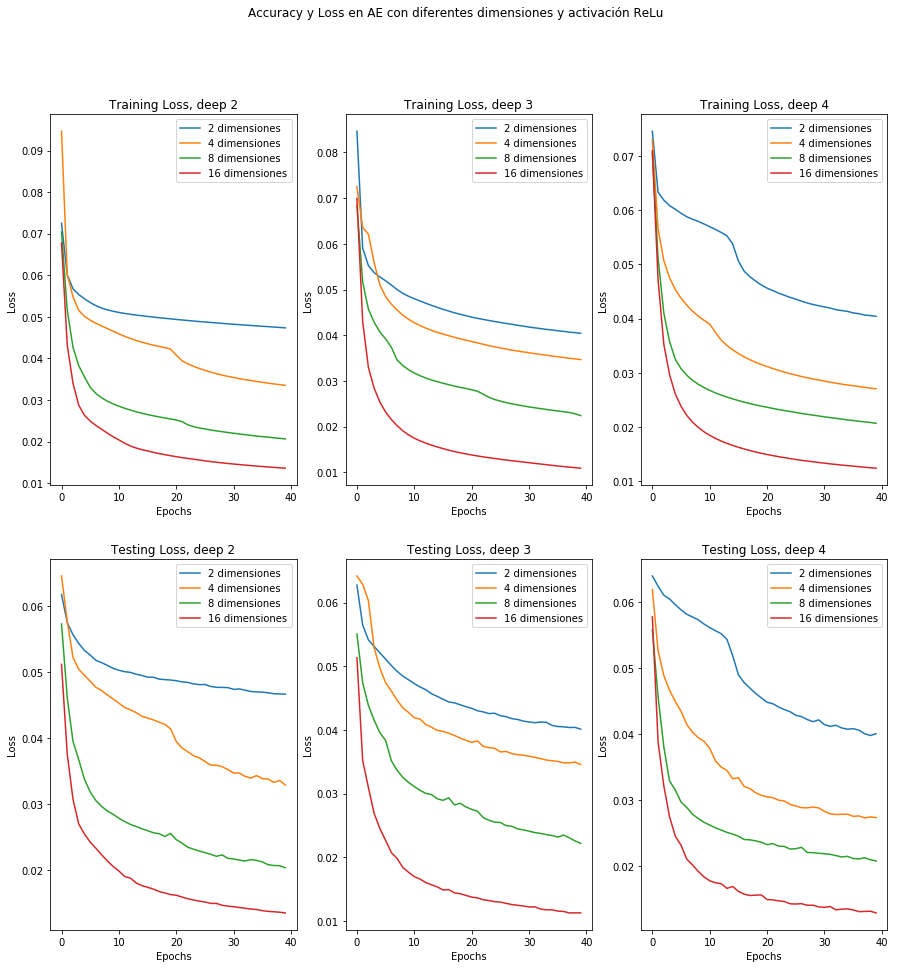

In [0]:
plot_dae(results)

Se puede ver como a medida que aumentan las dimensiones va disminuyendo el Loss tanto para el entrenamiento como para el testing. Para mejor comparación, se plotearan todas las curvas juntas.

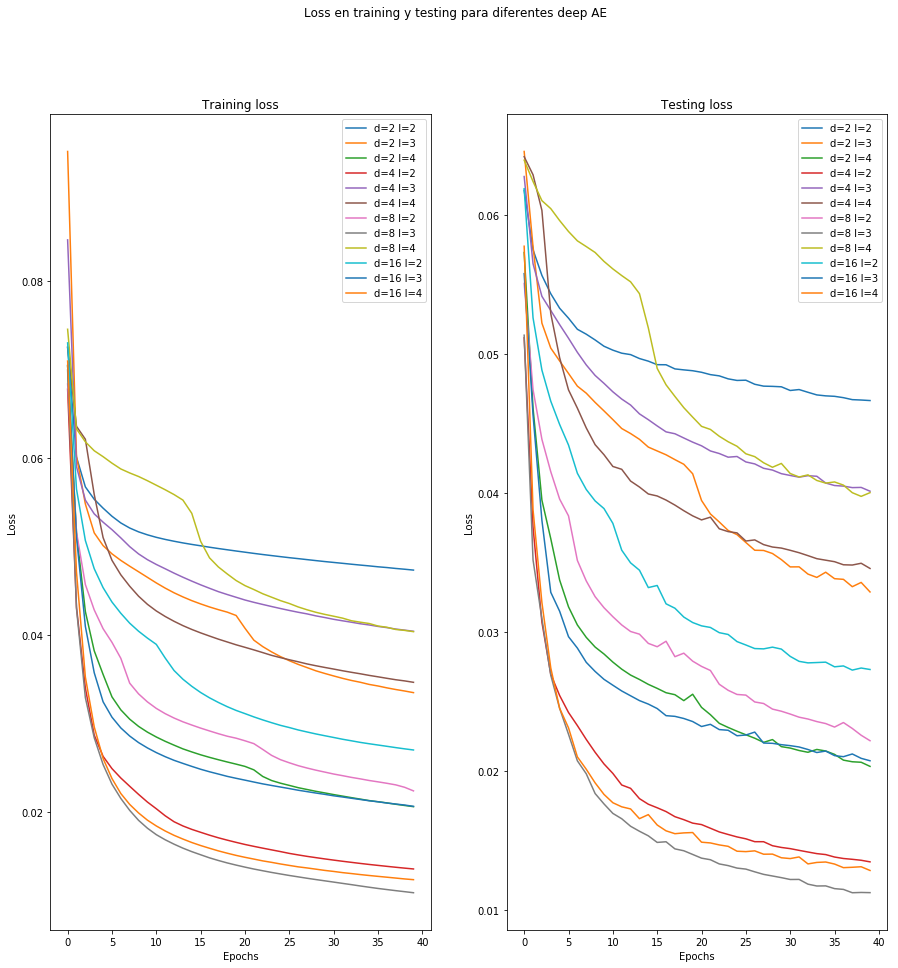

In [0]:
plot_all_dae(results)

En los gráficos se muestra que el autoencoder con profundidad 3 y dimensión 8 es la que alcanza una menor pérdida tanto en testing como en training. Desafortunadamente este resultado está erroeno y fue generado por la mal construcción del gráfico. La línea que se encuentra más abajo corresponde al autoencoder con profundidad 3 y dimensión 16. Le siguen los modelos con dimensión 16 y profundidad 4 y luego el con profundidad 3.

In [0]:
dims = [2,4,8,16]
L = [2,3,4]
for deep in L:
    print("Profundidad utilizada: %d" % deep)
    for d in dims:
        print("Dimensión utilizada: %d" % d)
        #PCA
        pca = PCA(n_components=d)
        pca.fit(x_train)
        pca_train = pca.transform(x_train)
        pca_test = pca.transform(x_test)
        #AUTOENCODER
        encoder = load_model("ae_p2/my_autoencoder_768x1000x500x250x"+str(d)+"x"+str(deep)+".h5")
        #encoder = load_model("./ae_p2/basic_ae_relu_768x"+str(d)+".h5")
        encoded_train = encoder.predict(x_train)
        encoded_test = encoder.predict(x_test)
        #CLASIFICATION
        start_time = time.time()
        clf = KNeighborsClassifier(10)
        clf.fit(pca_train, y_train)
        print("-Classification Accuracy PCA %.4f" % clf.score(pca_test,y_test))
        print("--Tiempo:{:.4f}".format(time.time()-start_time))
        start_time = time.time()
        clf = KNeighborsClassifier(10)
        clf.fit(encoded_train, y_train)
        print("-Classification Accuracy %.4f" % clf.score(encoded_test,y_test))
        print("--Tiempo:{:.4f}\n".format(time.time()-start_time))

Profundidad utilizada: 2
Dimensión utilizada: 2
-Classification Accuracy PCA 0.4425
--Tiempo:0.0782
-Classification Accuracy 0.6191
--Tiempo:10.2833

Dimensión utilizada: 4
-Classification Accuracy PCA 0.6484
--Tiempo:0.1686
-Classification Accuracy 0.8185
--Tiempo:36.2051

Dimensión utilizada: 8
-Classification Accuracy PCA 0.9029
--Tiempo:0.9559
-Classification Accuracy 0.9247
--Tiempo:263.2680

Dimensión utilizada: 16
-Classification Accuracy PCA 0.9615
--Tiempo:7.6832
-Classification Accuracy 0.9573
--Tiempo:515.5434

Profundidad utilizada: 3
Dimensión utilizada: 2
-Classification Accuracy PCA 0.4425
--Tiempo:0.0909
-Classification Accuracy 0.7070
--Tiempo:11.0599

Dimensión utilizada: 4
-Classification Accuracy PCA 0.6483
--Tiempo:0.1641
-Classification Accuracy 0.7941
--Tiempo:25.5294

Dimensión utilizada: 8
-Classification Accuracy PCA 0.9030
--Tiempo:1.0372
-Classification Accuracy 0.9288
--Tiempo:210.9211

Dimensión utilizada: 16
-Classification Accuracy PCA 0.9615
--Tiempo:6.

Se tienen resultados en muy poco tiempo con PCA. Aunque parte con un resultado de accuracy mucho menor en las tres versiones de profundidad, al aumentar la dimensión mejor considerablemente su resultado, siendo dos veces mejor que el autoencoder. Por lo tanto, para este caso es una opción valida utilizar PCA.

> e) Elija algunas de las representaciones aprendidas anteriormente y visualı́celas usando la herramienta *TSNE* disponible en la librerı́a *sklearn*. Compare cualitativamente el resultado con aquel obtenido usando PCA con el mismo número de componentes

t-distributed stochastic neighbor embedding, o t-SNE, es un algoritmo desarrollado por Laurens van der Maaten y Geoffrey Hinton para la visualización de datos de alta dimensión. Es una técnica de reducción de dimensionalidad no lineal que trabaja similitudes entre los puntos en el espacio, haciendo que objetos similares sean modelados por puntos cercanos y objetos diferentes sean modelados por puntos distantes con alta probabilidad.

t-SNE se divide en dos partes: primero, construye una distribución de probabilidad sobre pares de puntos en un espacio de alta dimensionalidad de tal forma en que puntos similares tendrán una alta probalidad de ser escogidos. Por el contrario, puntos diferentes tendrán una baja probabilidad. Luego, se define una distribución de probabilidad similar sobre los puntos en el mapa de baja dimensión, y minimiza la divergencia Kullback-Leibler entre las dos distribuciones con respecto a las ubicaciones de los puntos en el mapa. Tenga en cuenta que, si bien el algoritmo original utiliza la distancia euclidiana entre los objetos como la base de su métrica de similitud, esto se debe cambiar según corresponda. 

Se tomará un modelo anteriormente entrenado y se mostrarán 5000 puntos en un espacio 2D.

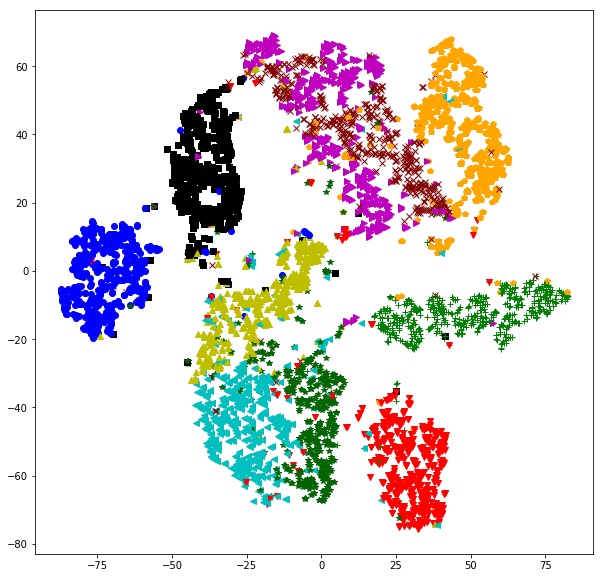

In [0]:
nplot=5000 #warning: mind your memory!
encoder = load_model("ae_p2/my_autoencoder_768x1000x500x250x8x3.h5")
encoded_train = encoder.predict(x_train[:nplot])
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(encoded_train)
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in range(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)

En el espacio 2D se distinguen diferentes conjuntos de datos que pasan a ser clusters. Según las etiquetas entregadas al gráfico se puede distinguir, por ejemplo, que los ceros son de color negro y los 7 naranja. Se obtiene una mejor distinción y clasificación de los datos cuando estos cluster se encuentran separados unos de otros. En este caso, existen muchos valores de números que se encuentran en otros clusters.

Para contrastar los resultados se aplicará PCA y se gráficará en 2D los resultados.

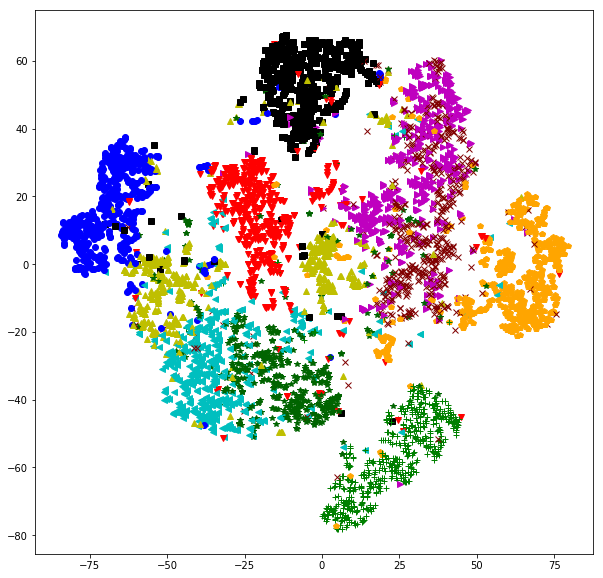

In [0]:
d = 8; l = 3
pca = PCA(n_components=d)
pca.fit(x_train)
pca_train = pca.transform(x_train)
encoded_train = pca_train[:nplot]
pca_test = pca.transform(x_test)
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(encoded_train)
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in range(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)

Con PCA existe un mayor solapamiento de los datos que sin PCA. En el caso anterior había una mayor separación de los datos en algunos sectores.

> f) Modifique el autoencoder construido en (a) para trabajar directamente sobre las imágenes de MNIST, sin tratarlas como vectores de 784 atributos, sino como matrices de tamaño $1\times28\times28$. Es posible lograr este objetivo utilizando capas convolucionales para definir el Encoder y el Decoder, comente como sufre las transformaciones el patrón de entrada. Compare la calidad de la representación reducida obtenida por el nuevo autoencoder con aquella obtenida anteriormente utilizando el mismo número de dimensiones. Comente.

A diferencia de la instanciación previa de los datos, se realiza un cambio de dimensión para que las matrices sean de tamaño 1x28x28. 

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) #modify for th dim ordering
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [0]:
print("x_train size: {}".format(x_train.shape))
print("x_test size: {}".format(x_test.shape))
print("Y_train size: {}".format(Y_train.shape))
print("Y_test size: {}".format(Y_test.shape))

x_train size: (60000, 28, 28, 1)
x_test size: (10000, 28, 28, 1)
Y_train size: (60000, 10)
Y_test size: (10000, 10)


Puesto que las imágenes serán tratas como matrices de dos dimensiones se puede trabajan con capas convolucionales para hacer el proceso de reconstrucción.

In [0]:
input_img = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 14, 14, 8)         0         
__________

/home/nacho/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
start_time = time.time()
hist = autoencoder.fit(x_train,x_train,epochs=40,batch_size=32,validation_split=val_ratio,verbose=0)
duration = time.time() - start_time
autoencoder.save('ae_p2/ae_f.h5')
print("Duración ae conv: {}".format(duration))

Duración ae conv: 735.756865978241


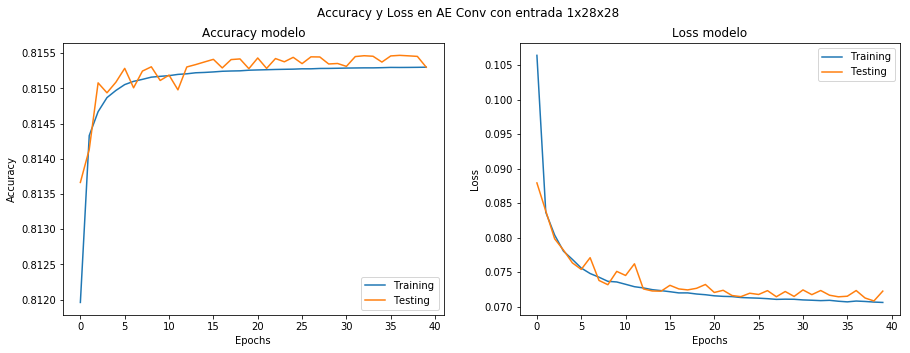

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
ax = axes.flatten()
ax[0].plot(hist.history["acc"], label="Training")
ax[0].plot(hist.history["val_acc"], label="Testing")
ax[1].plot(hist.history["loss"], label="Training")
ax[1].plot(hist.history["val_loss"], label="Testing")
    
ax[0].set_title('Accuracy modelo')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend()
ax[1].set_title('Loss modelo')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend()
plt.suptitle("Accuracy y Loss en AE Conv con entrada 1x28x28")
plt.show()

Para el AE entrenado, la acurracy va aumentando a medida que aumentan los epochs y teniendo mejores resultados en testing que en training. Esto quiere decir que el modelo logra generalizar algo más que los datos aprendidos durante el entrenamiento. Por otro lado, el loss disminuye a medida que aumentan los epochs. Para este caso hay un pequeño grado de overfitting al tener mejor perdida en el entrenamiento que en el testing.

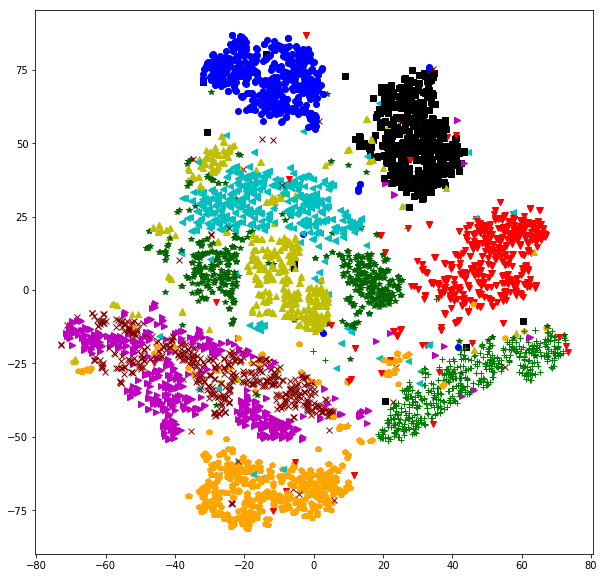

In [0]:
nplot=5000 #warning: mind your memory!
encoder = load_model("ae_p2/ae_f.h5")
encoded_train = encoder.predict(x_train[:nplot])
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(np.reshape(encoded_train,(5000,784)))
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in range(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)

Con TSNE ahora hay una distinción de clusters más que nada en los datos que quedan hubicados al exterior del conjunto de datos, como los puntos naranjos, los + verdes, los rojos, negros y azules. Para los datos hubicados al centros hay todavía un solapamiento y división en el caso de los verde claro.

En este paso, el autoencoder sugiere un mejor trabajo reflejado en los gráficos de su accuracy y loss.

### 3.2 Denoising
Como se ha discutido en clases, un denoising autoencoder (dAE) es esencialmente un autoencoder entrenado para reconstruir ejemplos parcialmente corruptos. Varios autores han demostrado que mediante esta modificación simple es posible obtener representaciones más robustas y significativas que aquellas obtenidas por un AE básico. En esta sección exploraremos la aplicación más “natural” o “directa” del método.

> a) Genere artificialmente una versión corrupta de las imágenes en MNIST utilizando el siguiente modelo de ruido (masking noise): si $x\in {\rm I\!R}^d$ es una de las imágenes originales, la versión ruidosa $\~{x}$ se obtiene como $\~{x} = x \odot \xi$ donde $\odot$ denota el producto de Hadamard (componente a componente) y $\xi \in {\rm I\!R}^d$ es un vector aleatorio binario con componentes *Ber(p)* independientes.

Volvemos a cargar los datos para ser procesados de forma diferente.

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255. #and x_test
x_test = x_test.astype('float32') / 255.

Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

11493376/11490434 [==============================] - 1s 0us/step


Se aplicará una capa de ruido binomial (números entre 0 y 1). Este ruido estará tanto en los datos de entrenamiento como en los datos de test. No será igual para ambas pues los números son generados previamente a cada multiplicación con la capa.

In [0]:
noise_level = 0.1
noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
noisy_x_test = x_test*noise_mask

Se define la función corrupt_img que aplica el ruido descrito anteriormente a un conjunto de training y testing.

In [0]:
def corrupt_img(noise_level):
    noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
    noisy_x_train = x_train*noise_mask
    noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
    noisy_x_test = x_test*noise_mask
    return noisy_x_train, noisy_x_test

Se cargan de nuevo los datos y se define una función que aplicará ruido a las imágenes para ver si es posible reconstruir a partir de una imagen perturbada.

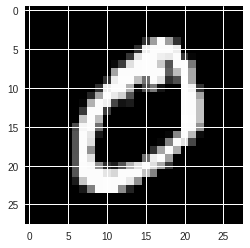

In [4]:
plt.imshow(x_train[1].reshape(28,28), cmap='gray')
plt.show()

Con un noise level de 0.1 la imagen con un cero de arriba a penas se ve y por lo mismo es difícil distinguir que número podría haber sido antes de aplicar el ruido.

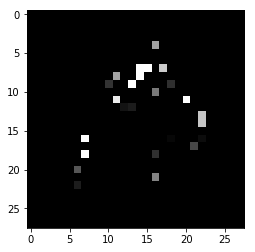

In [0]:
plt.imshow(noisy_x_train[1].reshape(28,28), cmap='gray')
plt.show()

Con 0.7 son menos los puntos que se pierden. Así, suponemos que entre mayor sea el noise_level le será más fácil reconstruir la imagen al autoencoder.

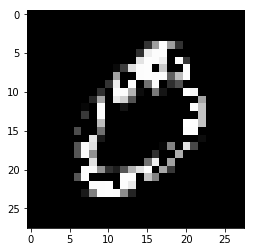

In [0]:
plt.imshow(noisy_x_train[1].reshape(28,28), cmap='gray')
plt.show()


> b) Entrene un autoencoder para reconstruir las imágenes corruptas generadas en el ı́tem anterior. Mida el error de reconstrucción y evalúe cualitativamente (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes. Experimente diferentes valores de *p* en el rango (0, 1).

Se probará el efecto del ruido para los siguientes valores de noise level [0.1,0.2,0.4,0.6,0.8].

In [0]:
dim = 8
deep = 4
noise_level = [0.1,0.2,0.4,0.6,0.8]
results = []
print("-AE deep:{} dim:{}-".format(deep, dim))
for noise in noise_level:
    noisy_x_train, noisy_x_test = corrupt_img(noise)
    print("noise:{}".format(noise))
    input_img = Input(shape=(784,))
    encoded1 = Dense(1000, activation='relu')(input_img)
    encoded2 = Dense(500, activation='relu')(encoded1)
    encoded3 = Dense(250, activation='relu')(encoded2)
    encoded4 = Dense(dim, activation='relu')(encoded3)
    decoded4 = Dense(250, activation='relu')(encoded4)
    decoded3 = Dense(500, activation='relu')(decoded4)
    decoded2 = Dense(1000, activation='relu')(decoded3)
    decoded1 = Dense(784, activation='sigmoid')(decoded2)         
    autoencoder = Model(input=input_img, output=decoded1)
    autoencoder.compile(optimizer=SGD(lr=1.0), loss="mean_squared_error", metrics=["accuracy"])
    start_time = time.time()
    hist = autoencoder.fit(noisy_x_train, x_train,epochs=40,batch_size=32,validation_split=val_ratio,verbose=0)
    print("-Tiempo: {:.3f}".format(time.time()-start_time))
    results.append(hist.history)
    autoencoder.save("ae_p2/corruptx"+str(noise)+".h5")

-AE deep:3 dim:8-
noise:0.1


/home/nacho/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


-Tiempo: 1211.350
noise:0.2
-Tiempo: 1224.786
noise:0.4
-Tiempo: 1230.153
noise:0.6
-Tiempo: 1204.620
noise:0.8
-Tiempo: 1255.303


En términos de tiempo no hay una directa relación entre lo que se demora en entrenar un modelo y si es que este demora más o menos.

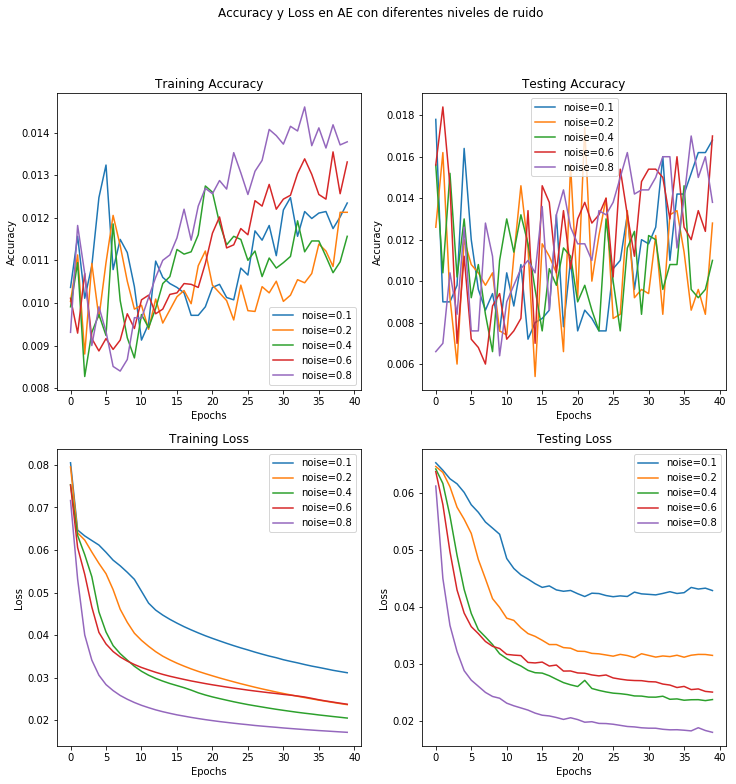

In [0]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,12))
ax = axes.flatten()
for i,noise in enumerate(noise_level):
    ax[0].plot(results[i]["acc"], label="noise="+str(noise))
    ax[1].plot(results[i]["val_acc"], label="noise="+str(noise))
    ax[2].plot(results[i]["loss"], label="noise="+str(noise))
    ax[3].plot(results[i]["val_loss"], label="noise="+str(noise))
    
ax[0].set_title('Training Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend()
ax[1].set_title('Testing Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()
ax[2].set_title('Training Loss')
ax[2].set_ylabel('Loss')
ax[2].set_xlabel('Epochs')
ax[2].legend()
ax[3].set_title('Testing Loss')
ax[3].set_ylabel('Loss')
ax[3].set_xlabel('Epochs')
ax[3].legend()
plt.suptitle("Accuracy y Loss en AE con diferentes niveles de ruido")
plt.show()

Los gráficos de accuracy son tan fluctuantes que es difícil hacer un juicio de valor acerca de sus datos. En el caso de los gráficos de pérdida se comprobó lo afirmado de que a mayor noise level sería más fácil para el AE reconstruir la imagen, y por enden, perder menos información de la imagen original.

In [0]:
def show_results_corrupt(noise):
    print("AE noise level:{}".format(noise))
    noise_mask = binomial(n=1,p=noise,size=x_test.shape)
    noisy_x_test = x_test*noise_mask
    autoencoder = load_model("ae_p2/corruptx"+str(noise)+".h5")
    encoded_test = autoencoder.predict(x_test)
    print("error[Loss, Acc]:{}".format(autoencoder.evaluate(x_test,x_test)))

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(noisy_x_test[i].reshape(28, 28),cmap='gray')
        plt.title("Noisy img")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(encoded_test[i].reshape(28, 28),cmap='gray')
        plt.title("Reconstrucción")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
    nplot=3000 #warning: mind your memory!
    encoded_train = autoencoder.predict(x_train[:nplot])
    model = TSNE(n_components=2, random_state=0)
    encoded_train = model.fit_transform(np.reshape(encoded_train,(3000,784)))
    plt.figure(figsize=(10, 10))
    colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
    markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
    for idx in range(0,nplot):
        label = y_train[idx]
        line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
            color=colors[label], marker=markers[label], markersize=6)

AE noise level:0.1
10000/10000 [==============================] - 3s 319us/step
error[Loss, Acc]:[0.06674048035144806, 0.0093]


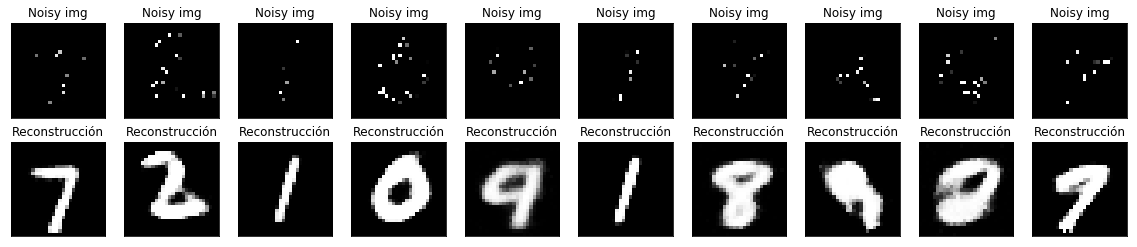

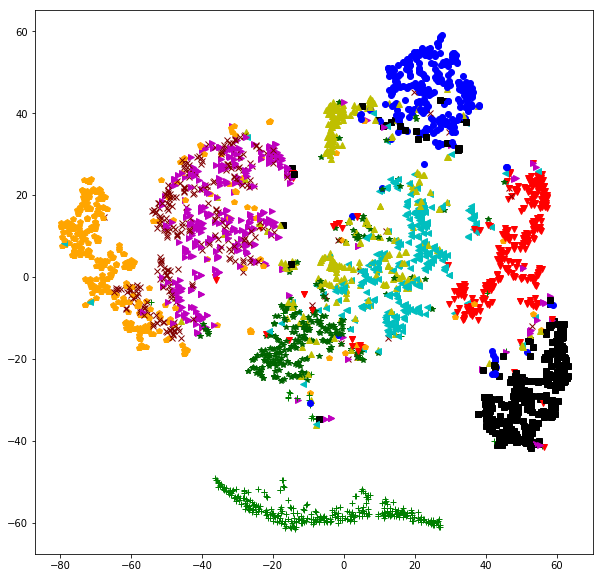

In [0]:
show_results_corrupt(0.1)

AE noise level:0.4
10000/10000 [==============================] - 3s 302us/step
error[Loss, Acc]:[0.04020551894903183, 0.0091]


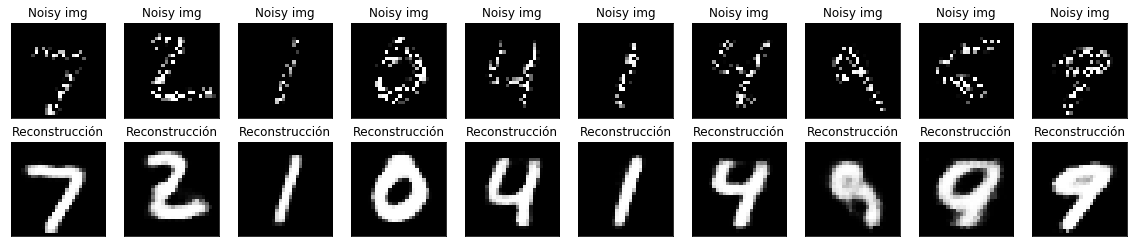

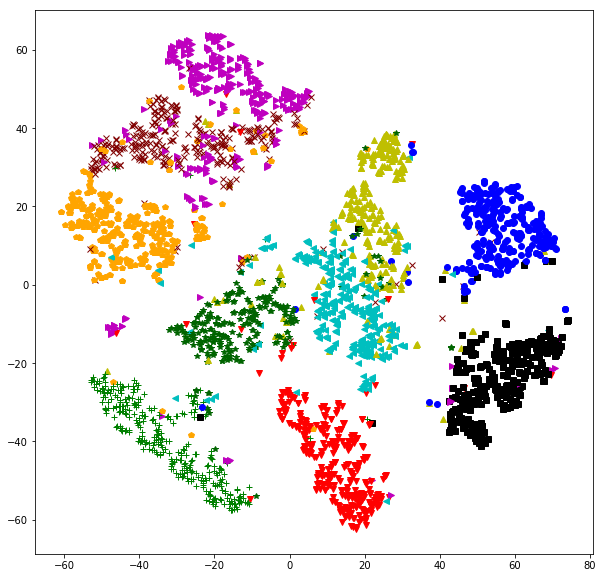

In [0]:
show_results_corrupt(0.4)

AE noise level:0.6
10000/10000 [==============================] - 3s 319us/step
error[Loss, Acc]:[0.030170442074537278, 0.0147]


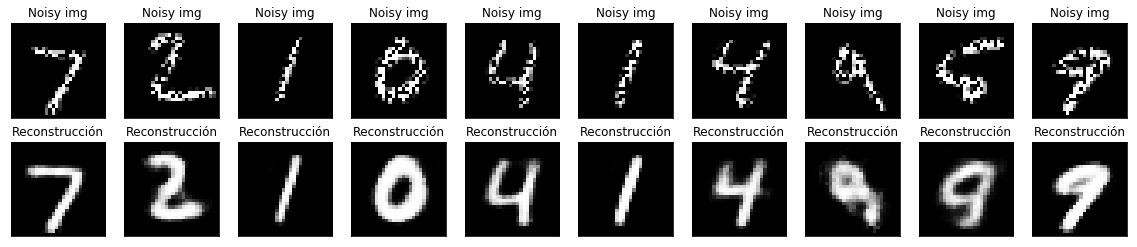

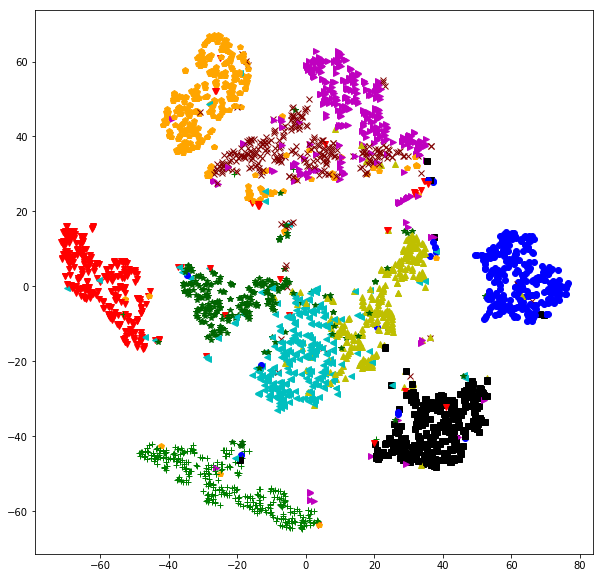

In [0]:
show_results_corrupt(0.6)

AE noise level:0.8
10000/10000 [==============================] - 3s 323us/step
error[Loss, Acc]:[0.01952744071781635, 0.0134]


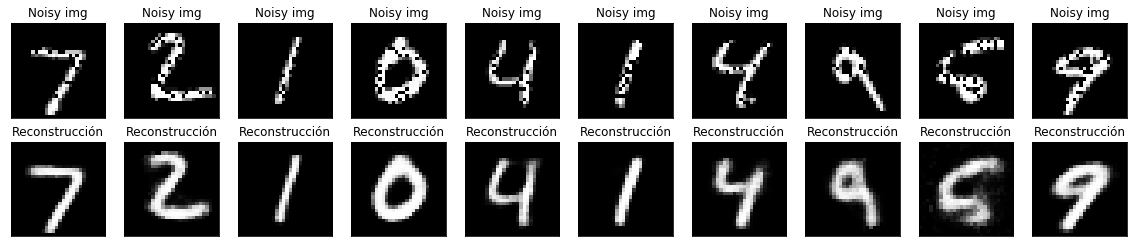

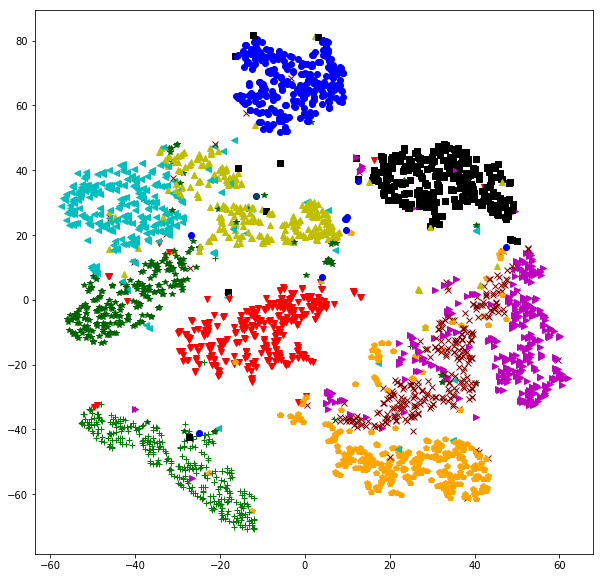

In [0]:
show_results_corrupt(0.8)

Es interesante que al tener tan pocos puntos los AE logren reconstruir la una imagen casi a la perfección. El único problema que tienen es que al tener menor información los números reconstruidos son de líneas más gruesas. Esto podría explicarse porque el modelo tiene un mayor grado de incertidumbre en esas áreas, fenómeno contrario que ocurre cuando hay una mayor concentración de datos lo que genera número con líneas más delgadas. Cuando hay más ruido también le cuesta al modelo distinguir los número con más curvas tomando los cuatro y cinco como nueves. Para ruidos de 0.4 y 0.6 hay una mejor separación de los cluster de números.

Es esperable que mientras menor sea el ruido menor es la pérdida.

> c) Utilice estas imágenes intencionalmente corruptas para entrenar un AE con fines de reducción de dimensionalidad. Durante el entrenamiento, proceda exactamente como en (b), pero su objetivo no será hacer *denoising* sino obtener una representación comprimida de alta calidad de las imágenes originales. Al final del entrenamiento, mida el error de reconstrucción como el desempeño en clasificación (vı́a kNN como en la sección anterior) de la representación obtenida. Comente.



In [0]:
noise_level = [0.1,0.2,0.4,0.6,0.8]
dim = 8
deep = 3
print("Profundidad utilizada: %d" % deep)
print("Dimensión utilizada: %d" % dim)
    
#PCA
pca = PCA(n_components=8)
pca.fit(x_train)
pca_train = pca.transform(x_train)
pca_test = pca.transform(x_test)
#CLASIFICATION
start_time = time.time()
clf = KNeighborsClassifier(10)
clf.fit(pca_train, y_train)
print("-Classification Accuracy PCA %.4f" % clf.score(pca_test,y_test))
print("--Tiempo:{:.4f}".format(time.time()-start_time))

for noise in noise_level:
    #AUTOENCODER
    encoder = load_model("ae_p2/corruptx"+str(noise)+".h5")
    encoded_train = encoder.predict(x_train)
    encoded_test = encoder.predict(x_test)
    #CLASIFICATION
    start_time = time.time()
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, y_train)
    print("-Classification noise:{} Accuracy: {:.4f}".format(noise, clf.score(encoded_test,y_test)))
    print("--Tiempo:{:.4f}\n".format(time.time()-start_time))

Profundidad utilizada: 3
Dimensión utilizada: 8
-Classification Accuracy PCA 0.9031
--Tiempo:1.1893
-Classification noise:0.1 Accuracy: 0.8586
--Tiempo:100.4616

-Classification noise:0.2 Accuracy: 0.9159
--Tiempo:190.0499

-Classification noise:0.4 Accuracy: 0.9325
--Tiempo:262.4882

-Classification noise:0.6 Accuracy: 0.9217
--Tiempo:219.3110

-Classification noise:0.8 Accuracy: 0.9461
--Tiempo:437.8624



In [0]:
#PCA
pca = PCA(n_components=16)
pca.fit(x_train)
pca_train = pca.transform(x_train)
pca_test = pca.transform(x_test)
#CLASIFICATION
start_time = time.time()
clf = KNeighborsClassifier(10)
clf.fit(pca_train, y_train)
print("-Classification Accuracy PCA %.4f" % clf.score(pca_test,y_test))
print("--Tiempo:{:.4f}".format(time.time()-start_time))

-Classification Accuracy PCA 0.9614
--Tiempo:8.6802


Se generón dos resultados con PCA, con 8 y 16 componentes. Comparando PCA con AE de 8 componentes, los AE tienen mejores resultados pero a tiempos de entrenamiento mayores. Cuando se aumenta la cantidad de componentes a PCA mejora su accuracy siendo mejor que los otros modelos. Es sorprendente la calidad de solución alcanzada con tan poco tiempo de ejecución. 

> d) Diseñe otra manera de generar imágenes corruptas del dataset MNIST, por ejemplo algún tipo de ruido, sea creativo. Mida el error de reconstrucción y evalúe cualitativamente (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes

Introduciremos un ruido dado por una función gamma. Este ruido será multiplicado por el noise level.

In [0]:
def corrupt_gamma(noise_level):
    noise_mask = gamma(0.5, scale=1, size=x_train.shape)
    noisy_x_train = x_train + noise_level*noise_mask
    noise_mask = gamma(0.5, scale=1, size=x_test.shape)
    noisy_x_test = x_test + noise_level*noise_mask
    return noisy_x_train, noisy_x_test

Por ejemplo, para el segundo ejemplo del set de entrenamiento (un cero) se tienen los siguientes resultados para diferentes valores de noise level. Mientras mayor sea el noise level el número irá desvaneciendose y se mezclará con el resto de los pixeles.

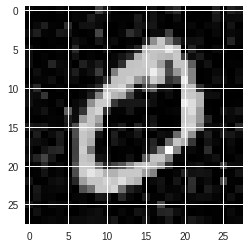

In [18]:
gamma_x_train, gamma_x_test = corrupt_gamma(0.1)
plt.imshow(gamma_x_train[1].reshape(28, 28),cmap='gray')
plt.show()

Si aumenta el noise level se desvance el número. Se espera que el autoencoder tenga peor reconstrucción a medida que aumenta el noise level.

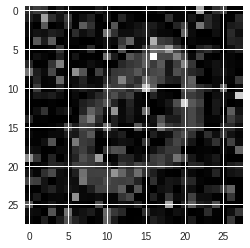

In [23]:
gamma_x_train, gamma_x_test = corrupt_gamma(0.8)
plt.imshow(gamma_x_train[1].reshape(28, 28),cmap='gray')
plt.show()

Para este nuevo autoencoder, se cambia la dimensión y se aplicará el ruido gamma. En cada iteración además se mostrará el efecto del ruido en la reconstrucción de la imagen.



In [0]:
def show_results_gamma(noise, autoencoder):
    print("AE noise level:{}".format(noise))
    noise_mask = gamma(0.5, scale=1, size=x_test.shape)
    noisy_x_test = x_test + noise_mask*noise
    #autoencoder = load_model("ae_p2/corruptx"+str(noise)+".h5")
    encoded_test = autoencoder.predict(x_test)
    print("error[Loss, Acc]:{}".format(autoencoder.evaluate(x_test,x_test)))

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(noisy_x_test[i].reshape(28, 28),cmap='gray')
        plt.title("Noisy img")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(encoded_test[i].reshape(28, 28),cmap='gray')
        plt.title("Reconstrucción")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

noise:0.1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  app.launch_new_instance()


-Tiempo: 350.755
AE noise level:0.1
10000/10000 [==============================] - 1s 91us/step
error[Loss, Acc]:[0.038916269749403, 0.0117]


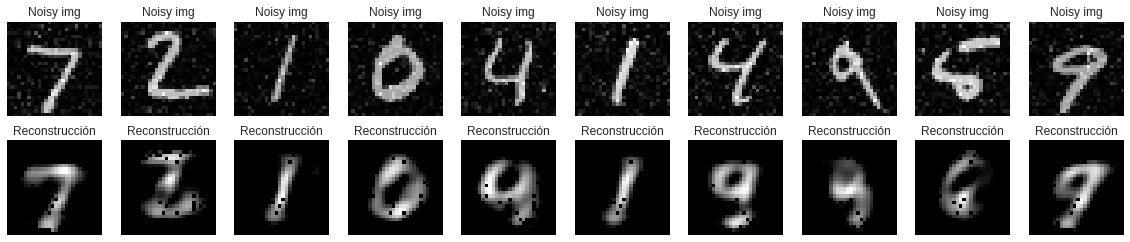

noise:0.5
-Tiempo: 336.015
AE noise level:0.5
10000/10000 [==============================] - 1s 78us/step
error[Loss, Acc]:[0.046795917785167694, 0.0108]


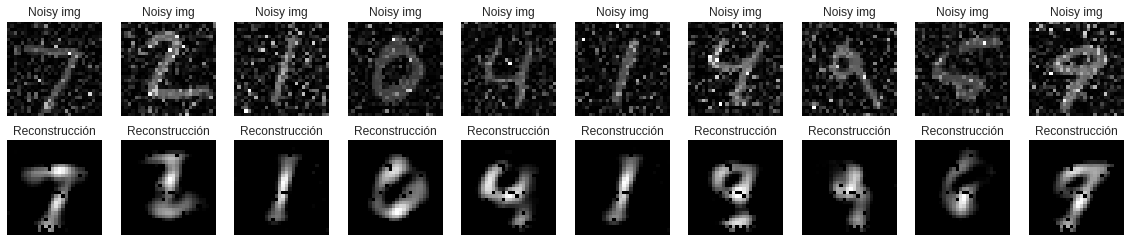

noise:0.9
-Tiempo: 321.409
AE noise level:0.9
10000/10000 [==============================] - 1s 85us/step
error[Loss, Acc]:[0.06649993557929992, 0.0147]


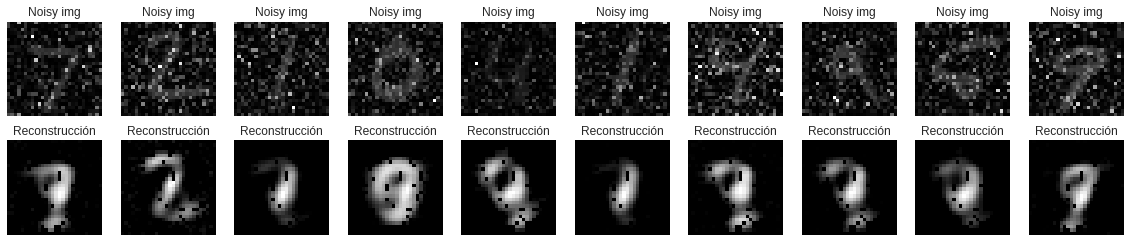

In [28]:
dim = 8
noise_level = [0.1,0.5,0.9]
results = []

for noise in noise_level:
    noisy_x_train, noisy_x_test = corrupt_gamma(noise)
    print("noise:{}".format(noise))

    input_img = Input(shape=(784,))
    encoded = Dense(dim, activation='relu')(input_img)
    decoded = Dense(784, activation='relu')(encoded)
    autoencoder = Model(input=input_img, output=decoded)
    encoder = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='mean_squared_error', metrics=['accuracy'])
    
    start_time = time.time()
    hist = autoencoder.fit(noisy_x_train, x_train,epochs=40,batch_size=32,validation_split=val_ratio,verbose=0)
    print("-Tiempo: {:.3f}".format(time.time()-start_time))
    results.append(hist.history)
    show_results_gamma(noise, autoencoder)    

A medida que aumenta el nivel de ruido va desapareciendo el dígito y se va mezclando con la tonalidad del fondo. Con poco ruido el autoencoder ya tiene problemas reconociendo números con curvas, y a medida que se va notando menos el número va reconstruyendo algo que no se logra identificar que es.

Ahora analizamos los gráficos de pérdida y accuracy.

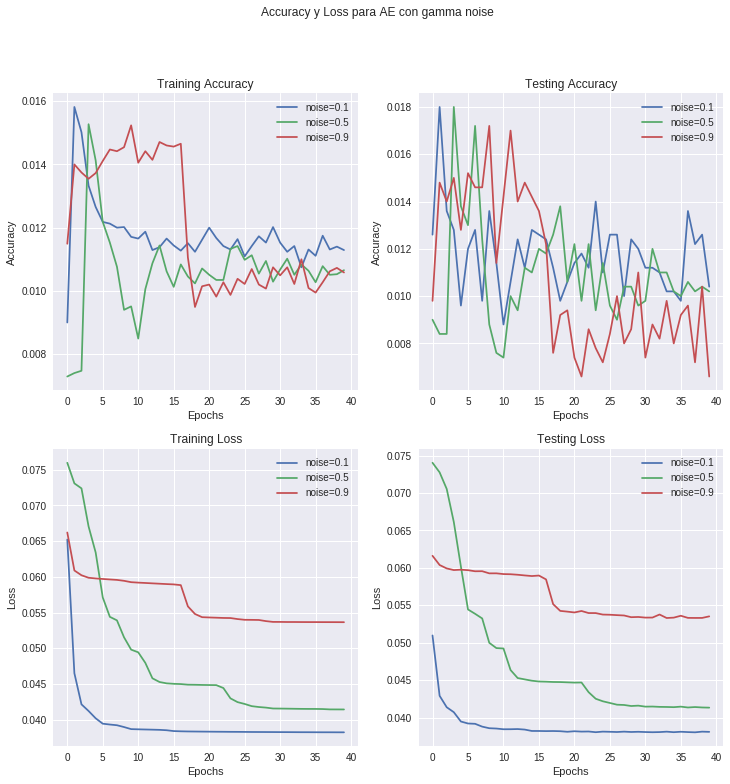

In [30]:
noise_level = [0.1,0.5,0.9]
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,12))
ax = axes.flatten()
for i,noise in enumerate(noise_level):
    ax[0].plot(results[i]["acc"], label="noise="+str(noise))
    ax[1].plot(results[i]["val_acc"], label="noise="+str(noise))
    ax[2].plot(results[i]["loss"], label="noise="+str(noise))
    ax[3].plot(results[i]["val_loss"], label="noise="+str(noise))
    
ax[0].set_title('Training Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend()
ax[1].set_title('Testing Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()
ax[2].set_title('Training Loss')
ax[2].set_ylabel('Loss')
ax[2].set_xlabel('Epochs')
ax[2].legend()
ax[3].set_title('Testing Loss')
ax[3].set_ylabel('Loss')
ax[3].set_xlabel('Epochs')
ax[3].legend()
plt.suptitle("Accuracy y Loss para AE con gamma noise")
plt.show()

Como era de esperar, para bajor valores de noise level sería más fácil para la red poder reconstruir los números, pero los resultados son muy bajos en comparación a los de 3.a. Aunque los números se pudieran ver de forma clara para bajos valores de noise level existe mucho ruido en las imágenes y la tonalidad del color de número se va mezclando con la del fondo, por lo que cuesta aun más identificar y a futuro reconstruir los dígitos. En relación a la accuracy no hay una tendencia clara a qué modelo tiene un mejor resultado y depende mucho del momento en que se detiene en entrenamiento.